In [1]:
import time
import tensorflow as tf
import wandb
import pandas as pd
from prosit_t.wandb_agent.train_utils import get_proteometools_data
import seaborn as sns
from dlomix.losses import masked_spectral_distance, masked_pearson_correlation_distance
import os
from dlomix.models import PrositIntensityPredictor

2023-08-24 13:52:57.334595: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-24 13:52:57.444929: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-08-24 13:52:58.120304: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-08-24 13:52:58.120357: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
# physical_devices = tf.config.list_physical_devices("GPU")
# tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [3]:
data_config = {
    "data_source": {
        "train": "/cmnfs/proj/prosit/Transformer/first_pool_train.parquet",
        "val": "/cmnfs/proj/prosit/Transformer/first_pool_test.parquet",
    },
    "fragmentation": "HCD",
    "batch_size": 1024,
    "seq_length": 30,
}

In [4]:
project_name = "transforming-prosit-big-data"
run = wandb.init(project=project_name)

wandb: Currently logged in as: mamisashvili-lizi (prosit-compms). Use `wandb login --relogin` to force relogin


In [5]:
artifact_paths = [
    "prosit-compms/transforming-prosit-first-pool/model-glamorous-night-50:v19",
    "prosit-compms/transforming-prosit-first-pool/model-chocolate-silence-59:v19"
]

In [17]:
given_names = [
    "6t_embed64_dense4_ffdim32",
    "6t_embed64_dense4_no_fusion"
]

In [35]:
def record_time(artifact_paths, batch, given_names):
    df = pd.DataFrame(columns=["artifact_name", "given_name", "time"])
    for idx, path in enumerate(artifact_paths):
        artifact = run.use_artifact(path)
        model_dir = artifact.download()
        model = tf.keras.models.load_model(model_dir, custom_objects={
            "masked_spectral_distance": masked_spectral_distance,
            "masked_pearson_correlation_distance": masked_pearson_correlation_distance
        })
        start_time = time.time()
        model(batch)
        end_time = time.time()
        time_diff = end_time - start_time
        model_name = path.split("/")[-1]
        df = df.append({
            "artifact_name": model_name,
            "given_name": given_names[idx],
            "time": time_diff
        }, ignore_index=True)
    return df

In [7]:
_, val_data = get_proteometools_data(data_config)

2023-08-24 13:53:56.782825: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-24 13:53:57.137538: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43648 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:e2:00.0, compute capability: 8.6


In [8]:
batch = [i[0] for i in val_data.take(1)][0]

In [36]:
df = record_time(artifact_paths, batch, given_names)

wandb:   4 of 4 files downloaded.  
2023-08-24 16:33:49.260491: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA A40" frequency: 1740 num_cores: 84 environment { key: "architecture" value: "8.6" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 6291456 shared_memory_size_per_multiprocessor: 102400 memory_size: 45768966144 bandwidth: 696096000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
/tmp/ipykernel_1151387/2546239800.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
wandb:   4 of 4 files downloaded.  
2023-08-24 16:33:52.748661: W tensorflow/core/grappler/

In [37]:
df

,artifact_name,given_name,time
0,model-glamorous-night-50:v19,6t_embed64_dense4_ffdim32,0.358074
1,model-chocolate-silence-59:v19,6t_embed64_dense4_no_fusion,0.283374


## baseline

In [10]:
baseline_path = "prosit-compms/transforming-prosit-first-pool/model-classic-star-15:v19"
baseline_artifact = run.use_artifact(baseline_path)
baseline_dir = baseline_artifact.download()

wandb:   4 of 4 files downloaded.  


In [11]:
baseline = PrositIntensityPredictor(seq_length=30,embedding_output_dim=16,
        recurrent_layers_sizes=(256, 512))

In [12]:
baseline.load_weights(baseline_dir)

2023-08-24 13:54:25.114390: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ./artifacts/model-classic-star-15:v19: FAILED_PRECONDITION: artifacts/model-classic-star-15:v19; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


In [38]:
start_time = time.time()
baseline(batch)
end_time = time.time()
time_dff = end_time - start_time
model_name = baseline_path.split("/")[-1]

array([[0.21534173],
       [0.21220897],
       [0.24663639],
       ...,
       [0.32626745],
       [0.21299644],
       [0.24857906]], dtype=float32)>, <tf.Tensor: shape=(1024, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>]. Consider rewriting this model with the Functional API.
array([[-0.15172893,  0.04987135, -0.35561872, ..., -0.3890507 ,
        -0.8873333 , -0.11872212],
       [-0.09067769,  0.12253203, -0.09175467, ...,  0.25554445,
        -0.73951197,  0.01048607],
       [ 0.06030523,  0.3424019 , -0.16427863, ..., -0.38893914,
        -0.8969771 , -0.04029872],
       ...,
       [ 0.4602992 ,  0.6751278 ,  0.16786389, ...,  0.31491935,
        -0.8998191 , -0.30336973],
       [ 0.55587864,  0.01062334,  0.05179136, ..., -0.3331563 ,
        -0.93493694,  0.20514537

In [39]:
df = df.append({
        "artifact_name": model_name,
        "given_name": "baseline",
        "time": time_dff
    }, ignore_index=True
)

/tmp/ipykernel_1151387/174103341.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


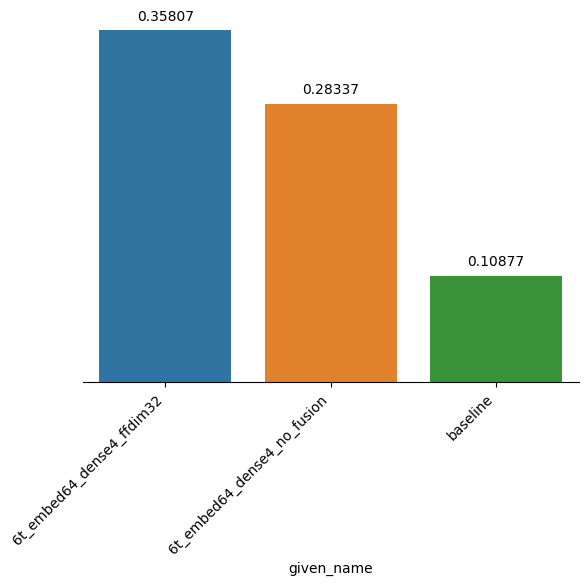

In [43]:
ax = sns.barplot(x="given_name", y="time", data=df)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.5f'), 
    (p.get_x() + p.get_width() / 2., p.get_height()), 
    ha = 'center', va = 'center', 
    xytext = (0, 10), 
    textcoords = 'offset points')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.yaxis.set_visible(False)
ax.grid(False, axis='y')
sns.despine(bottom = False, left = True)

In [44]:
!nvidia-smi

Thu Aug 24 16:38:54 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A40          Off  | 00000000:21:00.0 Off |                    0 |
|  0%   69C    P0   277W / 300W |   9468MiB / 46068MiB |     95%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A40          Off  | 00000000:81:00.0 Off |                    0 |
|  0%   